In [1]:

import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.models import Model

from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

import argparse
import os


C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
input_shape = (784, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# VAE model = encoder + decoder
# build encoder modeldef sampling(args):
    
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
____________________________________________________________________________________________

In [4]:
opt = keras.optimizers.Adam(learning_rate=0.01)
vae.compile(loss='categorical_crossentropy', optimizer=opt)

In [5]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [6]:
batch_history = LossHistory()


In [7]:
history = vae.fit(x_train, x_train, epochs=50, batch_size=256,
                          callbacks=[batch_history])

Epoch 1/50
60000/60000 [==============================] - 6s 102us/step - loss: 576.2352
Epoch 2/50
60000/60000 [==============================] - 6s 98us/step - loss: 564.5527
Epoch 3/50
60000/60000 [==============================] - 6s 96us/step - loss: 561.9566
Epoch 4/50
60000/60000 [==============================] - 6s 99us/step - loss: 560.8806
Epoch 5/50
60000/60000 [==============================] - 6s 95us/step - loss: 560.0399
Epoch 6/50
60000/60000 [==============================] - 6s 97us/step - loss: 559.3097
Epoch 7/50
60000/60000 [==============================] - 6s 104us/step - loss: 558.5776
Epoch 8/50
60000/60000 [==============================] - 6s 98us/step - loss: 558.0246
Epoch 9/50
60000/60000 [==============================] - 6s 98us/step - loss: 557.4679
Epoch 10/50
60000/60000 [==============================] - 6s 106us/step - loss: 556.8952
Epoch 11/50
60000/60000 [==============================] - 6s 101us/step - loss: 556.6700
Epoch 12/50
60000/60000 [=

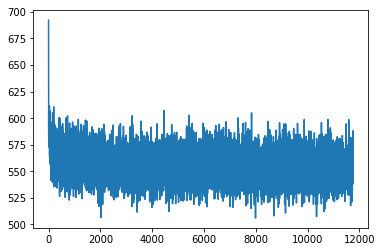

In [8]:
plt.plot(batch_history.losses)
plt.show()

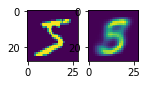

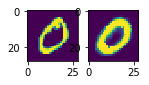

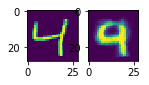

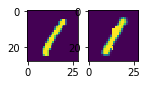

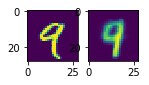

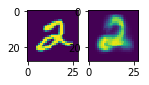

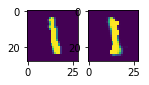

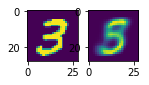

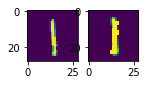

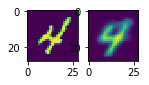

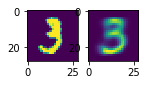

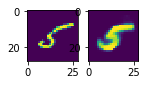

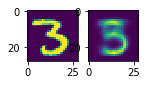

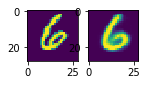

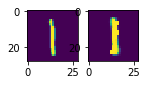

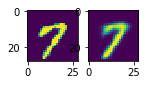

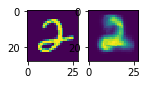

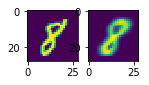

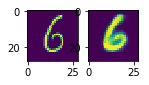

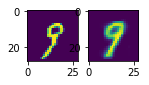

In [9]:

for i in range(20):
    _, axes = plt.subplots(1, 2, figsize=(2, 1))
    axes[0].imshow(x_train[i].reshape((28, 28)))
    axes[1].imshow(vae.predict(x_train[i:i+1]).reshape((28, 28)))
    plt.show

In [10]:
hidden = encoder.predict(x_train)
hid=np.array([*hidden])


In [42]:
images=np.zeros([100,28,28])
for i in range(10):
    near_mean=np.zeros([2,10])
    near_mean[0]= np.random.random(10)
    near_mean[1]=np.random.random(10)
    near_mean[0]=0.3*near_mean[0]*hid[2][y_train == i].std(axis=0)[0]+ hid[2][y_train == i].mean(axis=0)[0]
    near_mean[1]=0.3*near_mean[1]*hid[2][y_train == i].std(axis=0)[1]+ hid[2][y_train == i].mean(axis=0)[1]
    for j in range(10):
        images[i+10*j]=decoder.predict(near_mean.T[j:j+1]).reshape((28, 28))
images=images.tolist()

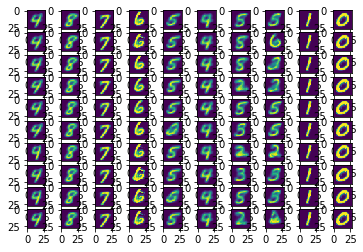

In [43]:
def show_images(images, cols = 10):
    n_images = len(images)
    fig = plt.figure()
    for n in range(n_images):
        fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(images.pop())
    plt.show()
show_images(images)